In [11]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion
from PIL import Image
from tqdm import tqdm

In [3]:
#Globals
DATA_ROOT = '/projects/sb2ek/datasets/nuscenes'

In [4]:


nusc = NuScenes(version='v1.0-mini', dataroot= DATA_ROOT, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.631 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [14]:
nusc.list_categories()


Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

In [15]:
nusc.list_attributes()


cycle.with_rider: 305
cycle.without_rider: 434
pedestrian.moving: 3875
pedestrian.sitting_lying_down: 111
pedestrian.standing: 1029
vehicle.moving: 2715
vehicle.parked: 4674
vehicle.stopped: 1545


In [16]:
my_instance = nusc.instance[27]
first_token = my_instance['first_annotation_token']
last_token = my_instance['last_annotation_token']
nbr_samples = my_instance['nbr_annotations']
current_token = first_token

i = 0
found_change = False
while current_token != last_token:
    current_ann = nusc.get('sample_annotation', current_token)
    current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']
    
    if i == 0:
        pass
    elif current_attr != last_attr:
        print("Changed from `{}` to `{}` at timestamp {} out of {} annotated timestamps".format(last_attr, current_attr, i, nbr_samples))
        found_change = True

    next_token = current_ann['next']
    current_token = next_token
    last_attr = current_attr
    i += 1

Changed from `pedestrian.moving` to `pedestrian.standing` at timestamp 21 out of 39 annotated timestamps


In [17]:
nusc.visibility


[{'description': 'visibility of whole object is between 0 and 40%',
  'token': '1',
  'level': 'v0-40'},
 {'description': 'visibility of whole object is between 40 and 60%',
  'token': '2',
  'level': 'v40-60'},
 {'description': 'visibility of whole object is between 60 and 80%',
  'token': '3',
  'level': 'v60-80'},
 {'description': 'visibility of whole object is between 80 and 100%',
  'token': '4',
  'level': 'v80-100'}]

Visibility: {'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}


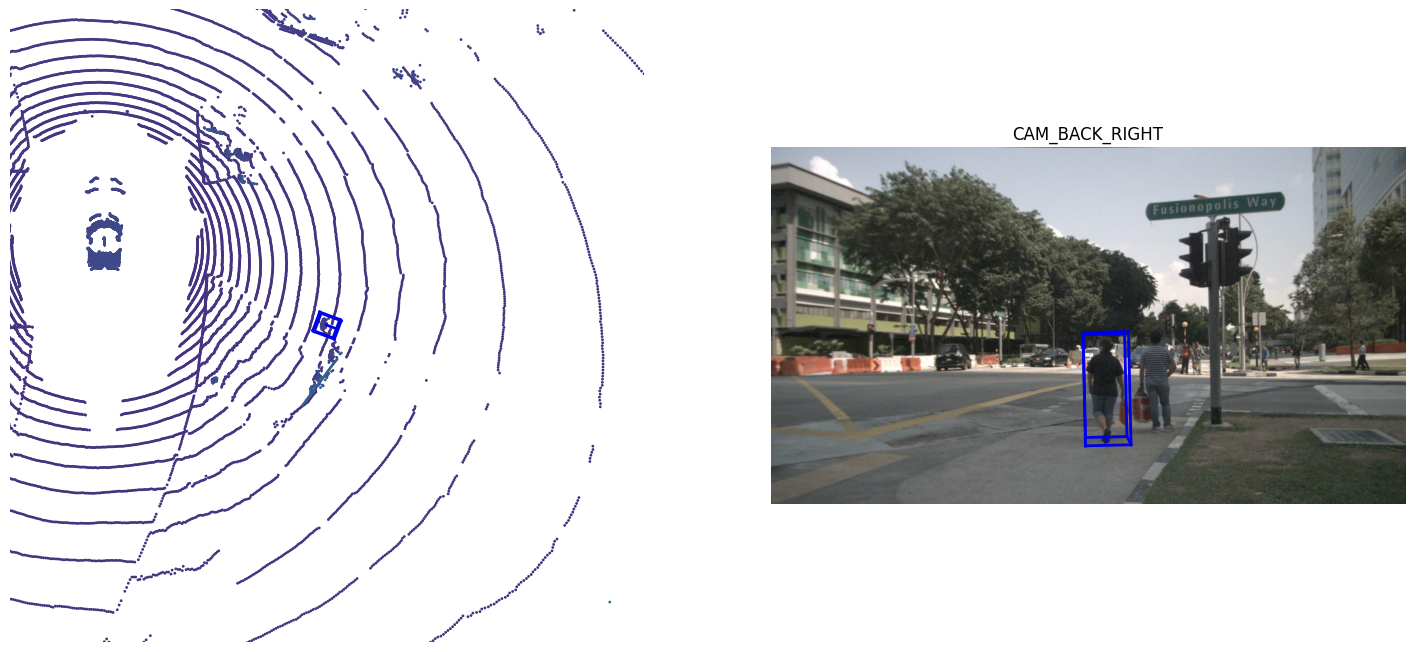

In [18]:
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

Visibility: {'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}


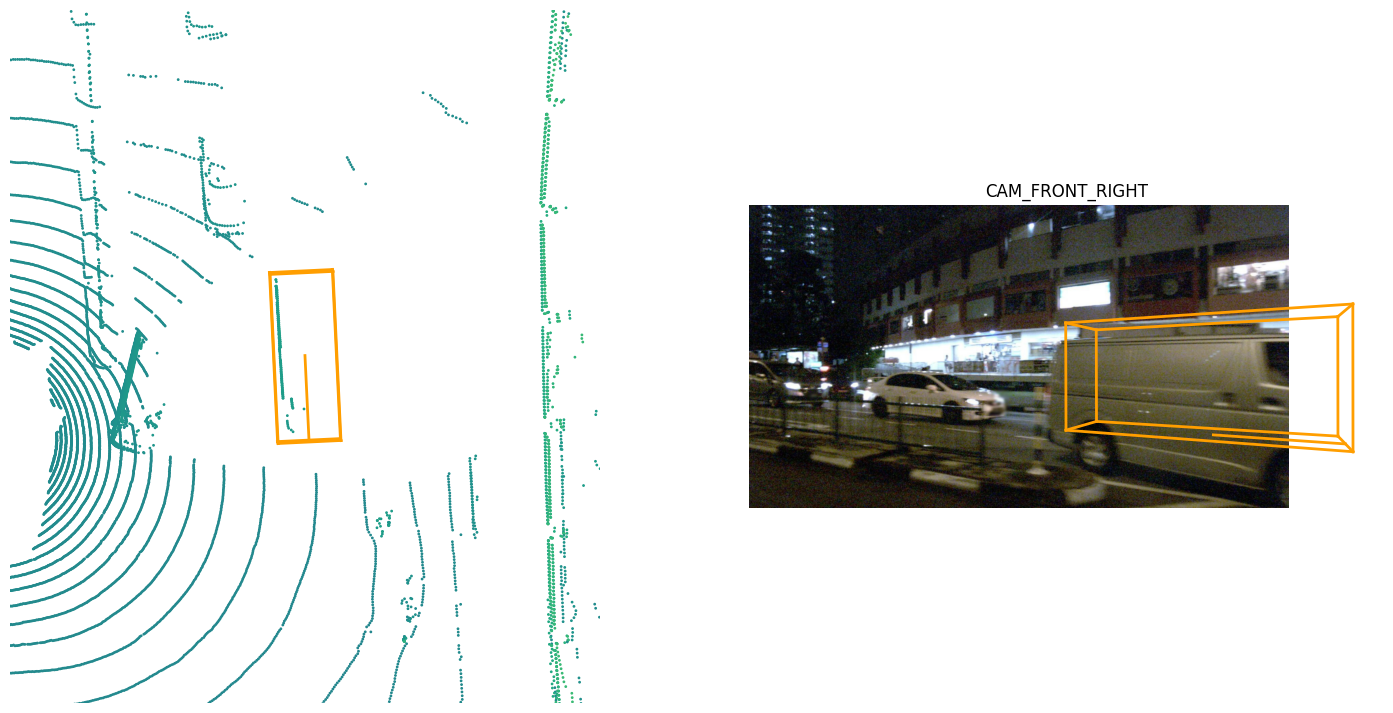

In [19]:
anntoken = '9f450bf6b7454551bbbc9a4c6e74ef2e'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

In [20]:
nusc.sensor


[{'token': '725903f5b62f56118f4094b46a4470d8',
  'channel': 'CAM_FRONT',
  'modality': 'camera'},
 {'token': 'ce89d4f3050b5892b33b3d328c5e82a3',
  'channel': 'CAM_BACK',
  'modality': 'camera'},
 {'token': 'a89643a5de885c6486df2232dc954da2',
  'channel': 'CAM_BACK_LEFT',
  'modality': 'camera'},
 {'token': 'ec4b5d41840a509984f7ec36419d4c09',
  'channel': 'CAM_FRONT_LEFT',
  'modality': 'camera'},
 {'token': '2f7ad058f1ac5557bf321c7543758f43',
  'channel': 'CAM_FRONT_RIGHT',
  'modality': 'camera'},
 {'token': 'ca7dba2ec9f95951bbe67246f7f2c3f7',
  'channel': 'CAM_BACK_RIGHT',
  'modality': 'camera'},
 {'token': 'dc8b396651c05aedbb9cdaae573bb567',
  'channel': 'LIDAR_TOP',
  'modality': 'lidar'},
 {'token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
  'channel': 'RADAR_FRONT',
  'modality': 'radar'},
 {'token': '232a6c4dc628532e81de1c57120876e9',
  'channel': 'RADAR_FRONT_RIGHT',
  'modality': 'radar'},
 {'token': '1f69f87a4e175e5ba1d03e2e6d9bcd27',
  'channel': 'RADAR_FRONT_LEFT',
  'modality'

In [21]:
nusc.sample_data[10]


{'token': '2ecfec536d984fb491098c9db1404117',
 'sample_token': '356d81f38dd9473ba590f39e266f54e5',
 'ego_pose_token': '2ecfec536d984fb491098c9db1404117',
 'calibrated_sensor_token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'timestamp': 1532402928269133,
 'fileformat': 'pcd',
 'is_key_frame': False,
 'height': 0,
 'width': 0,
 'filename': 'sweeps/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402928269133.pcd',
 'prev': 'b933bbcb4ee84a7eae16e567301e1df2',
 'next': '79ef24d1eba84f5abaeaf76655ef1036',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT'}

In [22]:
nusc.calibrated_sensor[0]

{'token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
 'translation': [3.412, 0.0, 0.5],
 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088],
 'camera_intrinsic': []}

In [23]:
nusc.ego_pose[0]


{'token': '5ace90b379af485b9dcb1584b01e7212',
 'timestamp': 1532402927814384,
 'rotation': [0.5731787718287827,
  -0.0015811634307974854,
  0.013859363182046986,
  -0.8193116095230444],
 'translation': [410.77878632230204, 1179.4673290964536, 0.0]}

In [24]:
print("Number of `logs` in our loaded database: {}".format(len(nusc.log)))

Number of `logs` in our loaded database: 8


In [22]:
nusc.log[0]


{'token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'logfile': 'n015-2018-07-24-11-22-45+0800',
 'vehicle': 'n015',
 'date_captured': '2018-07-24',
 'location': 'singapore-onenorth',
 'map_token': '53992ee3023e5494b90c316c183be829'}

Starting Multi-Scale Depth Generation. Inspect Mode: True


  0%|          | 0/404 [00:00<?, ?it/s]

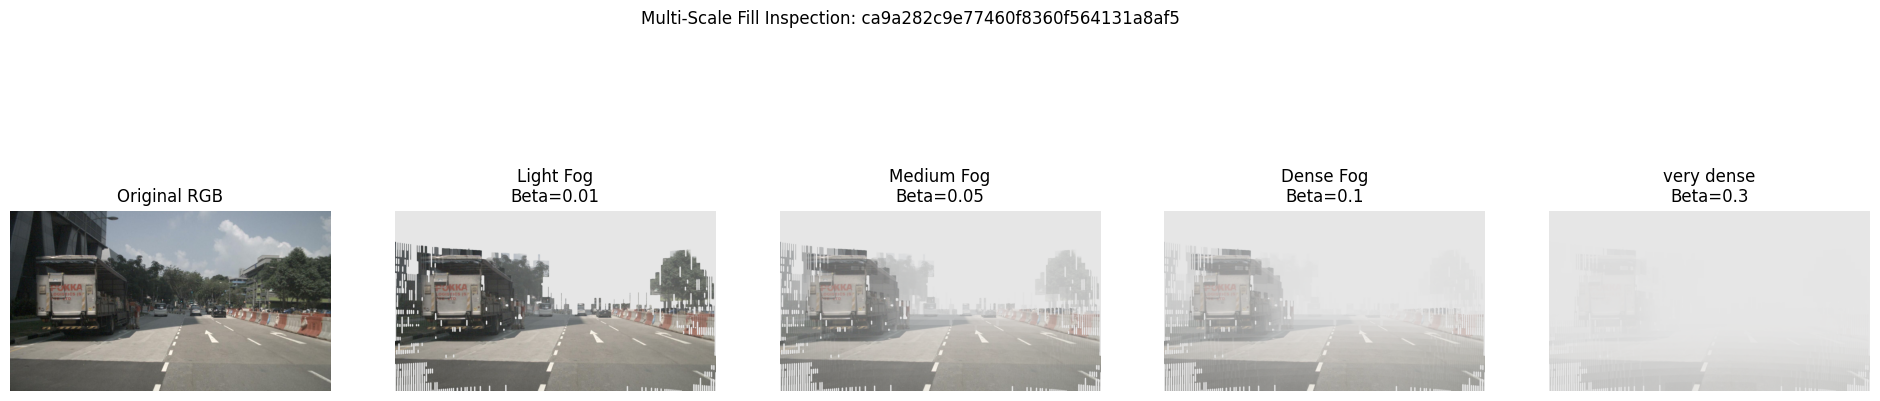

  0%|          | 0/404 [00:01<?, ?it/s]

Inspection complete.


In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points

# --- CONFIGURATION ---
OUTPUT_DIR = '/tmp/nuscenes_depth_multiscale' 
INSPECT_MODE = True  # Set to False to run the whole dataset

def fill_depth_multiscale(depth_map, rgb_image, max_depth=100.0):
    """
    Multi-Scale Vertical Closing to fix the 'Horizontal Blinds' artifact.
    It forcefully closes gaps of sizes 15, 31, and 81 pixels.
    """
    # 1. Invert Depth (so we dilate 'close' objects, not background)
    valid_pixels = depth_map > 0
    depth_map = np.clip(depth_map, 0, max_depth)
    inverted_depth = np.zeros_like(depth_map)
    inverted_depth[valid_pixels] = max_depth - depth_map[valid_pixels]
    
    # 2. Multi-Scale Dilation
    # We apply dilations of increasing vertical size to catch ALL gaps.
    # Level 1: Small gaps (Fine detail)
    k1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 15))
    d1 = cv2.dilate(inverted_depth, k1)
    
    # Level 2: Medium gaps
    k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 31))
    d2 = cv2.dilate(inverted_depth, k2)
    
    # Level 3: Huge gaps (Foreground scanlines)
    # This prevents the "white stripes" in the foreground road/truck
    k3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 81))
    d3 = cv2.dilate(inverted_depth, k3)
    
    # Combine: Take the maximum (closest object wins)
    # This ensures we don't lose the truck to the background.
    combined = np.maximum(np.maximum(d1, d2), d3)
    
    # 3. Fill remaining black holes (Salt & pepper noise)
    k_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, k_close)
    
    # 4. Invert Back to Depth
    rough_depth = np.zeros_like(closed)
    valid_closed = closed > 0
    rough_depth[valid_closed] = max_depth - closed[valid_closed]
    
    # 5. Guided Refinement (Snap to RGB edges)
    # This cleans up the "blocky" look from the huge kernels
    if hasattr(cv2, 'ximgproc'):
        refined = cv2.ximgproc.jointBilateralFilter(
            guide=rgb_image, 
            src=rough_depth.astype(np.float32), 
            d=15, 
            sigmaColor=15.0, 
            sigmaSpace=15.0
        )
        return refined
    else:
        # Fallback if opencv-contrib not installed
        return cv2.medianBlur(rough_depth.astype(np.float32), 5)
        
# --- HELPER FUNCTIONS ---
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def simulate_fog(rgb_image, depth_map_meters, beta=0.05, atmospheric_light=230):
    img_float = rgb_image.astype(np.float32)
    t = np.zeros_like(depth_map_meters)
    # Only treat strictly 0.0 as Sky. 
    valid_mask = depth_map_meters > 0
    t[valid_mask] = np.exp(-beta * depth_map_meters[valid_mask])
    
    t_3c = t[:, :, np.newaxis]
    radiance = img_float * t_3c
    fog = atmospheric_light * (1.0 - t_3c)
    return np.clip(radiance + fog, 0, 255).astype(np.uint8)

def get_sparse_depth(nusc, sample_rec, cam_channel='CAM_FRONT', min_dist=1.0):
    lidar_token = sample_rec['data']['LIDAR_TOP']
    cam_token = sample_rec['data'][cam_channel]
    lidar_rec = nusc.get('sample_data', lidar_token)
    cam_rec = nusc.get('sample_data', cam_token)
    
    pc_path = nusc.get_sample_data_path(lidar_token)
    pc = LidarPointCloud.from_file(pc_path)
    cs_record_cam = nusc.get('calibrated_sensor', cam_rec['calibrated_sensor_token'])
    cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])
    im_size = (cam_rec['width'], cam_rec['height'])
    
    # Transformation
    cs_record_lidar = nusc.get('calibrated_sensor', lidar_rec['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record_lidar['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record_lidar['translation']))
    pose_record_lidar = nusc.get('ego_pose', lidar_rec['ego_pose_token'])
    pc.rotate(Quaternion(pose_record_lidar['rotation']).rotation_matrix)
    pc.translate(np.array(pose_record_lidar['translation']))
    pose_record_cam = nusc.get('ego_pose', cam_rec['ego_pose_token'])
    pc.translate(-np.array(pose_record_cam['translation']))
    pc.rotate(Quaternion(pose_record_cam['rotation']).rotation_matrix.T)
    pc.translate(-np.array(cs_record_cam['translation']))
    pc.rotate(Quaternion(cs_record_cam['rotation']).rotation_matrix.T)
    
    # Project
    depths = pc.points[2, :]
    points = view_points(pc.points[:3, :], cam_intrinsic, normalize=True)
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im_size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im_size[1] - 1)
    points = points[:, mask]
    depths = depths[mask]
    
    depth_map = np.zeros((im_size[1], im_size[0]), dtype=np.float32)
    depth_map[points[1, :].astype(int), points[0, :].astype(int)] = depths
    return depth_map, cam_rec['filename']

# --- MAIN EXECUTION ---
def generate_nuscenes_depth_dataset(nusc, output_root, inspect=False):
    print(f"Starting Multi-Scale Depth Generation. Inspect Mode: {inspect}")
    if not inspect:
        cameras = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                   'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']
        for cam in cameras:
            ensure_dir(os.path.join(output_root, cam))

    for sample in tqdm(nusc.sample):
        cams_to_process = ['CAM_FRONT'] if inspect else [
            'CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
            'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT'
        ]
        
        for cam_channel in cams_to_process:
            # 1. Sparse Map
            sparse_map, filename = get_sparse_depth(nusc, sample, cam_channel)
            
            # Load RGB
            cam_token = sample['data'][cam_channel]
            cam_path = nusc.get_sample_data_path(cam_token)
            rgb_img = cv2.cvtColor(cv2.imread(cam_path), cv2.COLOR_BGR2RGB)
            
            # 2. Dense Map (New Multi-Scale Logic)
            dense_map = fill_depth_multiscale(sparse_map, rgb_img)
            
            if inspect:
                # Simulation
                fog_levels = [0.01, 0.05, 0.1, 0.3]
                foggy_imgs = [simulate_fog(rgb_img, dense_map, beta=b) for b in fog_levels]
                
                # Plotting
                fig, ax = plt.subplots(1, 5, figsize=(24, 6))
                ax[0].imshow(rgb_img)
                ax[0].set_title("Original RGB")
                ax[0].axis('off')
                
                titles = ["Light Fog", "Medium Fog", "Dense Fog", "very dense"]
                for j, f_img in enumerate(foggy_imgs):
                    ax[j+1].imshow(f_img)
                    ax[j+1].set_title(f"{titles[j]}\nBeta={fog_levels[j]}")
                    ax[j+1].axis('off')
                
                plt.suptitle(f"Multi-Scale Fill Inspection: {sample['token']}")
                plt.show()
                print("Inspection complete.")
                return 

            # 3. Save
            depth_int16 = (dense_map * 256).astype(np.uint16)
            original_name = os.path.basename(filename)
            save_name = os.path.splitext(original_name)[0] + '.png'
            save_path = os.path.join(output_root, cam_channel, save_name)
            cv2.imwrite(save_path, depth_int16)

# Run
generate_nuscenes_depth_dataset(nusc, OUTPUT_DIR, inspect=INSPECT_MODE)

In [35]:
nusc.sample[0]['data']['LIDAR_TOP']

'9d9bf11fb0e144c8b446d54a8a00184f'

Starting SLIC-Based Depth Generation. Inspect Mode: True


  0%|          | 0/404 [00:00<?, ?it/s]

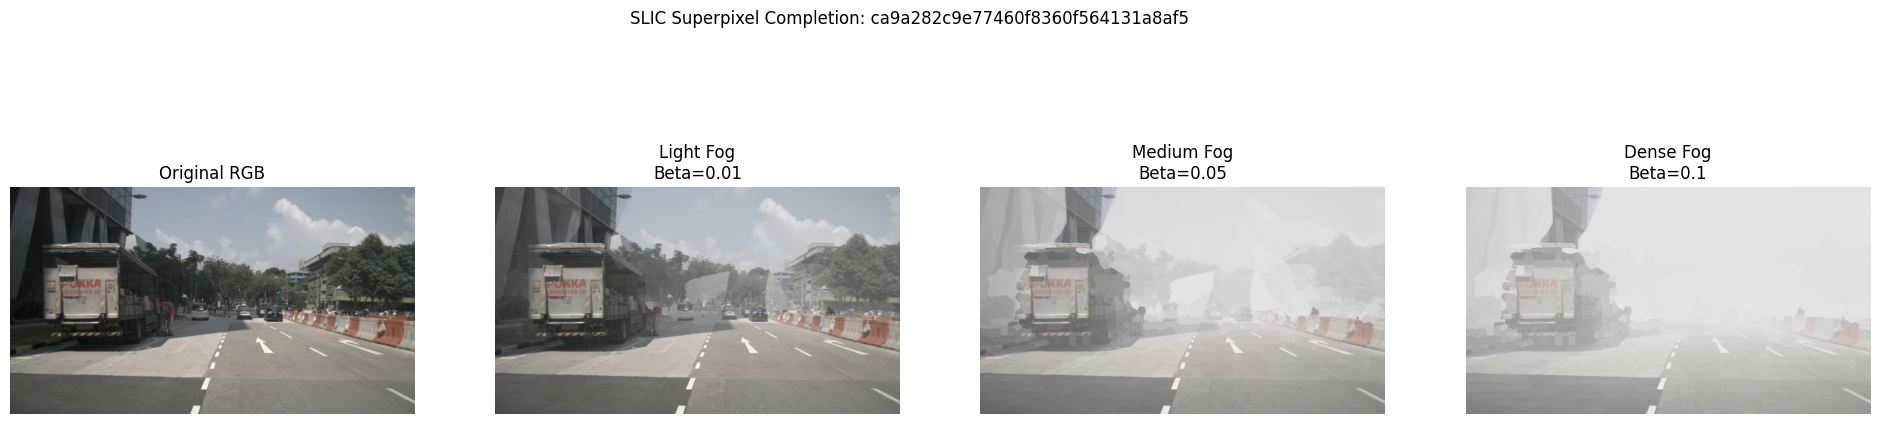

  0%|          | 0/404 [00:06<?, ?it/s]

Inspection complete.


In [33]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyquaternion import Quaternion
from skimage.segmentation import slic
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points

# --- CONFIGURATION ---
OUTPUT_DIR = '/tmp/nuscenes_foggy_slic'
INSPECT_MODE = True  # Set False to run on all samples

# --- 1. CORE UTILS ---

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def simulate_fog(rgb_image, depth_map_meters, beta=0.05, atmospheric_light=230):
    """
    Standard Fog Model: I = R * exp(-beta*d) + L * (1 - exp(-beta*d))
    """
    img_float = rgb_image.astype(np.float32)
    t = np.zeros_like(depth_map_meters)
    
    # Valid depth > 0 gets transmission. 0 (Sky) gets 0 transmission.
    valid_mask = depth_map_meters > 0
    t[valid_mask] = np.exp(-beta * depth_map_meters[valid_mask])
    
    t_3c = t[:, :, np.newaxis]
    radiance = img_float * t_3c
    fog = atmospheric_light * (1.0 - t_3c)
    return np.clip(radiance + fog, 0, 255).astype(np.uint8)

def get_sparse_depth(nusc, sample_rec, cam_channel='CAM_FRONT', min_dist=1.0):
    lidar_token = sample_rec['data']['LIDAR_TOP']
    cam_token = sample_rec['data'][cam_channel]
    lidar_rec = nusc.get('sample_data', lidar_token)
    cam_rec = nusc.get('sample_data', cam_token)
    
    pc_path = nusc.get_sample_data_path(lidar_token)
    pc = LidarPointCloud.from_file(pc_path)
    cs_record_cam = nusc.get('calibrated_sensor', cam_rec['calibrated_sensor_token'])
    cam_intrinsic = np.array(cs_record_cam['camera_intrinsic'])
    im_size = (cam_rec['width'], cam_rec['height'])
    
    # Coordinate Transforms
    cs_record_lidar = nusc.get('calibrated_sensor', lidar_rec['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record_lidar['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record_lidar['translation']))
    pose_record_lidar = nusc.get('ego_pose', lidar_rec['ego_pose_token'])
    pc.rotate(Quaternion(pose_record_lidar['rotation']).rotation_matrix)
    pc.translate(np.array(pose_record_lidar['translation']))
    pose_record_cam = nusc.get('ego_pose', cam_rec['ego_pose_token'])
    pc.translate(-np.array(pose_record_cam['translation']))
    pc.rotate(Quaternion(pose_record_cam['rotation']).rotation_matrix.T)
    pc.translate(-np.array(cs_record_cam['translation']))
    pc.rotate(Quaternion(cs_record_cam['rotation']).rotation_matrix.T)
    
    # Project
    depths = pc.points[2, :]
    points = view_points(pc.points[:3, :], cam_intrinsic, normalize=True)
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im_size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im_size[1] - 1)
    points = points[:, mask]
    depths = depths[mask]
    
    depth_map = np.zeros((im_size[1], im_size[0]), dtype=np.float32)
    # Sort by depth descending so closer points (processed last) overwrite far ones
    sort_idx = np.argsort(depths)[::-1]
    depth_map[points[1, sort_idx].astype(int), points[0, sort_idx].astype(int)] = depths[sort_idx]
    
    return depth_map, cam_rec['filename']

# --- 2. THE PAPER'S METHOD: SUPERPIXEL COMPLETION ---

def fill_depth_slic(sparse_depth, rgb_image, n_segments=2000, compactness=10):
    """
    Replicates the logic from arXiv:1708.07819.
    1. Computes SLIC superpixels on the RGB image (respects object boundaries).
    2. Assigns median depth of sparse points within each superpixel to the whole superpixel.
    """
    h, w = sparse_depth.shape
    
    # 1. Generate Superpixels (SLIC)
    # n_segments: Number of superpixels. Higher = finer detail (less blocky).
    # compactness: Balance between color proximity and space proximity.
    segments = slic(rgb_image, n_segments=n_segments, compactness=compactness, start_label=1)
    
    # 2. Assign Depth to Superpixels
    filled_depth = np.zeros_like(sparse_depth)
    
    # Get unique segment labels
    unique_segments = np.unique(segments)
    
    # We iterate over segments to fill them
    # (Optimized for speed using masking)
    for seg_id in unique_segments:
        mask = (segments == seg_id)
        
        # Find LiDAR points inside this superpixel
        points_in_seg = sparse_depth[mask]
        valid_points = points_in_seg[points_in_seg > 0]
        
        if len(valid_points) > 0:
            # Use Median to reject outliers (robust)
            # The paper uses "plane fitting", but median is the robust 0th order approximation
            seg_depth = np.median(valid_points)
            filled_depth[mask] = seg_depth
            
    # 3. Final Cleanup (Nearest Neighbor for empty superpixels)
    # Some small superpixels might not have ANY LiDAR points. 
    # We fill them using OpenCV inpainting (Telea) or nearest neighbor.
    mask_missing = ((filled_depth == 0) & (segments > 0)).astype(np.uint8)
    
    # Important: Protect the Sky!
    # We assume the top 10% of the image with depth 0 is sky, don't fill it.
    # Simple heuristic: Only fill if it's NOT a massive connected component at the top.
    # For now, a simple inpaint is usually safe if superpixels are small.
    if np.count_nonzero(mask_missing) > 0:
        filled_depth = cv2.inpaint(filled_depth.astype(np.float32), mask_missing, 3, cv2.INPAINT_TELEA)

    return filled_depth

# --- 3. MAIN PIPELINE ---

def generate_nuscenes_depth_dataset(nusc, output_root, inspect=False):
    print(f"Starting SLIC-Based Depth Generation. Inspect Mode: {inspect}")
    
    if not inspect:
        cameras = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                   'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']
        for cam in cameras:
            ensure_dir(os.path.join(output_root, cam))

    # Loop
    for sample in tqdm(nusc.sample):
        cams_to_process = ['CAM_FRONT'] if inspect else [
            'CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
            'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT'
        ]
        
        for cam_channel in cams_to_process:
            # 1. Sparse Map
            sparse_map, filename = get_sparse_depth(nusc, sample, cam_channel)
            
            # Load RGB (Required for SLIC)
            cam_token = sample['data'][cam_channel]
            cam_path = nusc.get_sample_data_path(cam_token)
            rgb_img = cv2.cvtColor(cv2.imread(cam_path), cv2.COLOR_BGR2RGB)
            
            # 2. Dense Map (The Paper's Method)
            # n_segments=2000 is a good balance for 1600x900 images.
            dense_map = fill_depth_slic(sparse_map, rgb_img, n_segments=2000)
            
            if inspect:
                # 3. Simulate Fog
                fog_levels = [0.01, 0.05, 0.1]
                foggy_imgs = [simulate_fog(rgb_img, dense_map, beta=b) for b in fog_levels]
                
                # Plot
                fig, ax = plt.subplots(1, 4, figsize=(24, 6))
                ax[0].imshow(rgb_img)
                ax[0].set_title("Original RGB")
                ax[0].axis('off')
                
                titles = ["Light Fog", "Medium Fog", "Dense Fog"]
                for j, f_img in enumerate(foggy_imgs):
                    ax[j+1].imshow(f_img)
                    ax[j+1].set_title(f"{titles[j]}\nBeta={fog_levels[j]}")
                    ax[j+1].axis('off')
                
                plt.suptitle(f"SLIC Superpixel Completion: {sample['token']}")
                plt.show()
                print("Inspection complete.")
                return 

            # Save
            depth_int16 = (dense_map * 256).astype(np.uint16)
            original_name = os.path.basename(filename)
            save_name = os.path.splitext(original_name)[0] + '.png'
            save_path = os.path.join(output_root, cam_channel, save_name)
            cv2.imwrite(save_path, depth_int16)

# --- EXECUTE ---
generate_nuscenes_depth_dataset(nusc, OUTPUT_DIR, inspect=INSPECT_MODE)